In [2]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [3]:
ts = pd.read_csv('datasets/time_series/demand_series.csv')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
ts.head()

,forecast,demand,net_demand
date,,,
2018-04-12 00:00:00,21942.0,21825.0,17634.0
2018-04-12 00:05:00,21661.0,21694.0,17555.0
2018-04-12 00:10:00,21661.0,21619.0,17430.0
2018-04-12 00:15:00,21661.0,21556.0,17331.0
2018-04-12 00:20:00,21494.0,21459.0,17197.0


## Hourly sampling
- This allows for forecasting data in megawatt hours in future methods

In [4]:
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.head(3)

(18504, 3)


,forecast,demand,net_demand
date,,,
2018-04-12 00:00:00,21429.250000,21373.250000,17073.333333
2018-04-12 01:00:00,20564.083333,20519.916667,16348.083333
2018-04-12 02:00:00,20070.083333,20067.416667,15830.250000


#### 72 hour trend sample
- Thurs/Fri/Saturday April 12-14
- Each day there are two peaks (11am, 10pm) and two minima (12 noon, 1am)
- Saturday shows much lower morning output

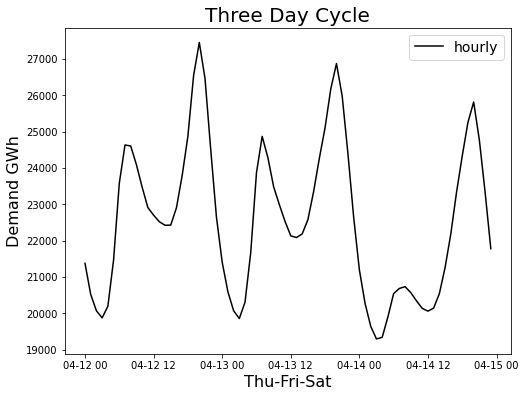

In [14]:
plt.figure(figsize=(8,6))
plt.plot(mwh['demand'][0:72],'k-',label='hourly')
plt.legend(fontsize=14)
plt.xlabel('Thu-Fri-Sat',fontsize=16)
plt.ylabel('Demand GWh',fontsize=16)
plt.title('Three Day Cycle',fontsize=20)
#plt.savefig('./images/three_day_cycle.png',dpi=235,bbox_inches='tight');

## Daily Sampling
- Mean of power in MWh produced each day
- Clear weekly trend with weekends lower than weekdays
- Appears to be a seasonal trend with more demand in the summer and late summer

In [9]:
ds = mwh.resample('D').mean()
ds.head(3)

,forecast,demand,net_demand
date,,,
2018-04-12,23186.263573,23164.906881,16380.165404
2018-04-13,23078.515152,23069.206439,17573.027146
2018-04-14,21503.301768,21475.017045,16372.051136


## Monthly Sampling
- Supply trends by fuel type showing monthly totals in MWh

In [11]:
ms = mwh.resample('M').mean()
ms.head(3)

,forecast,demand,net_demand
date,,,
2018-04-30,22858.806057,22839.483344,16804.712771
2018-05-31,23946.758207,23937.419436,16949.069485
2018-06-30,26780.101926,26761.350852,19537.449369


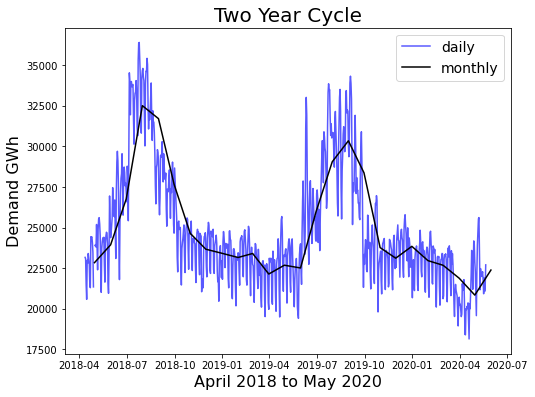

In [26]:
plt.figure(figsize=(8,6))
plt.plot(ds['demand'],'b-',label='daily',alpha=0.65)
plt.plot(ms['demand'],'k-',label='monthly')
plt.xlabel('April 2018 to May 2020',fontsize=16)
plt.ylabel('Demand GWh',fontsize=16)
plt.title('Two Year Cycle',fontsize=20)
plt.legend(fontsize=14);
#plt.savefig('./images/two_year_cycle.png',dpi=235,bbox_inches='tight');

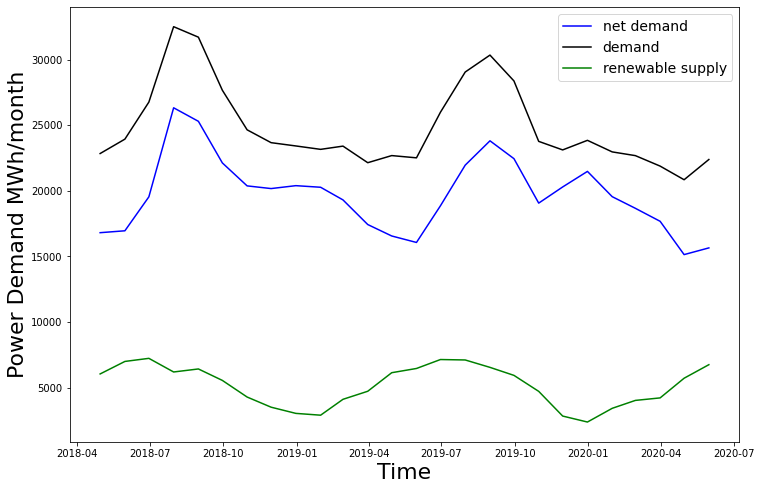

In [146]:
plt.figure(figsize=(12,8))
plt.plot(ms['net_demand'],'b-',label='net demand')
plt.plot(ms['demand'],'k-',label='demand')
plt.plot(ms['demand']-ms_tot['net_demand'],'g-',label='renewable supply')
plt.legend(fontsize=14)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Power Demand MWh/month',fontsize=22);

## Autocorrelation Models 

In [85]:
hourly = []
for i in range(96):
    hourly.append(mwh['demand'].autocorr(lag=i))

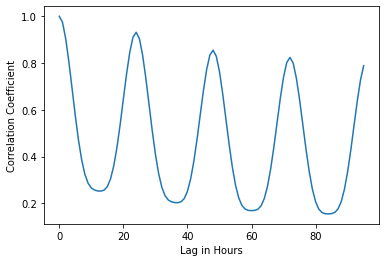

In [89]:
plt.plot(range(96),hourly)
plt.xlabel('Lag in Hours')
plt.ylabel('Correlation Coefficient');

In [73]:
weekly=[]
for i in range(35):
    weekly.append(ds['demand'].autocorr(lag=i))

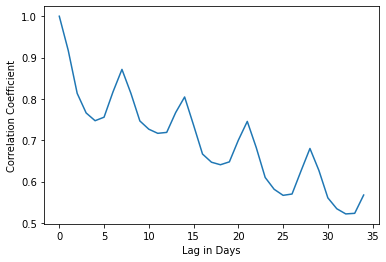

In [90]:
plt.plot(range(35),weekly)
plt.xlabel('Lag in Days')
plt.ylabel('Correlation Coefficient');

In [5]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

### Daily Autocorrelation Model

RMSE: 2406.6416932579705


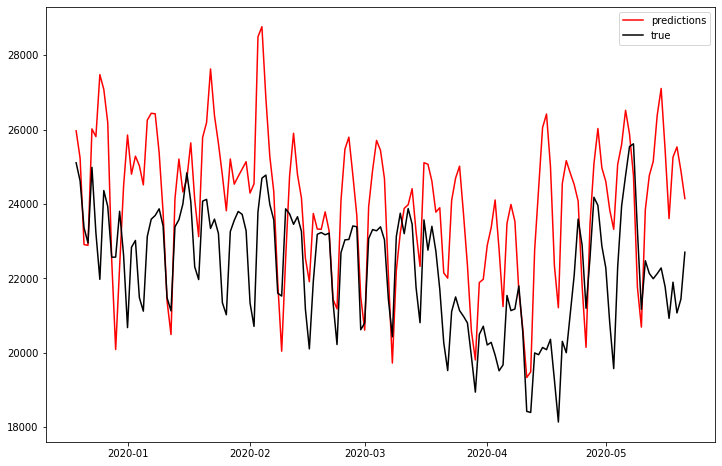

In [230]:
series = ds['demand'].fillna(np.mean(ds['demand']))
train,test = series[:int(0.8*len(series))], series[int(0.8*len(series)):]

model = AutoReg(train,lags=205)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

print(f"RMSE: {np.sqrt(mean_squared_error(test, predictions))}")
plt.figure(figsize=(12,8))
plt.plot(predictions,'r',label='predictions')
plt.plot(test,'k',label='true')
plt.legend();

### 5 week prediction

RMSE: 1902.8369189499965


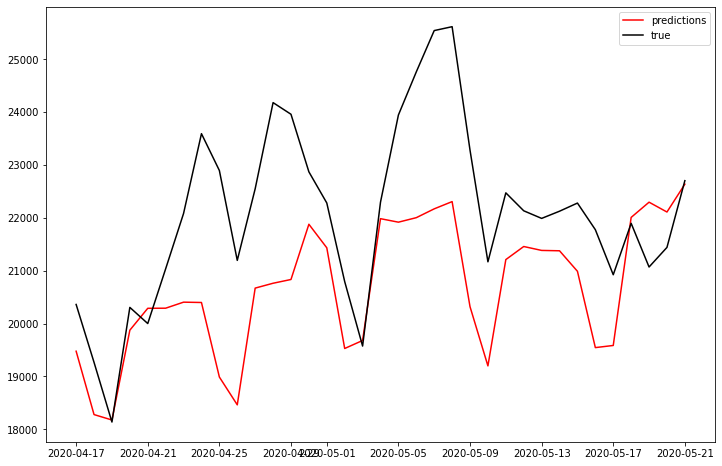

In [257]:
series = ds['demand'].fillna(np.mean(ds['demand']))
train,test = series[:-35], series[-35:]

model = AutoReg(train,lags=52*4)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

print(f"RMSE: {np.sqrt(mean_squared_error(test, predictions))}")
plt.figure(figsize=(12,8))
plt.plot(predictions,'r',label='predictions')
plt.plot(test,'k',label='true')
plt.legend();

### Week Ahead from Hourly Data
- forecasting a week out
- THIS ONE GOES AS THE INTITAL MODEL

RMSE = 1129.9214929571235


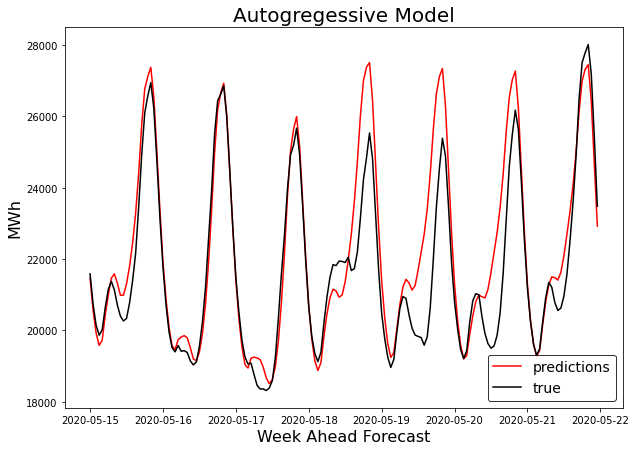

In [32]:
series = mwh['demand'].fillna(np.mean(mwh['demand']))
train,test = series[:24*7*-1], series[24*7*-1:]

model = AutoReg(train,lags=24*13)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

print(f"RMSE = {np.sqrt(mean_squared_error(test, predictions))}")

plt.figure(figsize=(10,7))
plt.plot(predictions,'r',label='predictions')
plt.plot(test,'k',label='true')
plt.xlabel('Week Ahead Forecast',fontsize=16)
plt.ylabel('MWh',fontsize=16)
plt.title('Autogregessive Model',fontsize=20)
plt.legend(fontsize=14,loc='lower right',edgecolor='k');
# plt.savefig('./images/autoregressive_model.png',dpi=235,bbox_inches='tight');

### Day Ahead from Five-minute Data

/Users/Sam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/Sam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RMSE = 1400.8739617588947


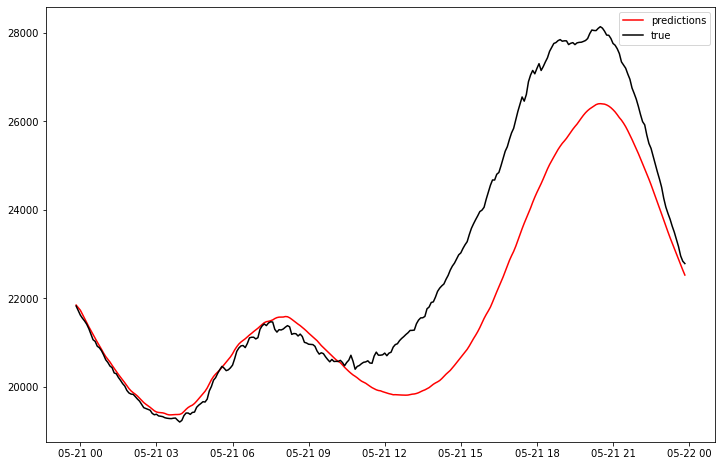

In [13]:
series = ts['demand'].fillna(np.mean(ts['demand']))
train,test = series[:-12*24], series[-12*24:]

model = AutoReg(train,lags=12*24)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

print(f"RMSE = {np.sqrt(mean_squared_error(test, predictions))}")

plt.figure(figsize=(12,8))
plt.plot(test.index,predictions,'r',label='predictions')
plt.plot(test.index,test,'k',label='true')
plt.legend();

## RNN Models